<a href="https://colab.research.google.com/github/joowop/Metaverse_AI_Project/blob/main/unet_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ml4py/dataset-iiit-pet

Cloning into 'dataset-iiit-pet'...
remote: Enumerating objects: 18465, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 18465 (delta 1), reused 3 (delta 1), pack-reused 18460
Receiving objects: 100% (18465/18465), 772.55 MiB | 31.44 MiB/s, done.
Resolving deltas: 100% (3678/3678), done.
Updating files: 100% (18477/18477), done.


In [ ]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
import cv2

images = sorted(glob.glob('./dataset-iiit-pet/images/*.jpg'))

for temp in images:
    result = cv2.imread(temp,cv2.IMREAD_COLOR)
    cv2.imwrite(temp,result)

    if result.shape[2] == 4: #png확인
        print(temp)

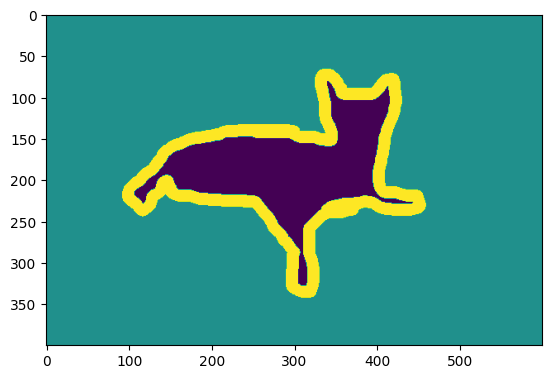

In [ ]:
annotation = Image.open('./dataset-iiit-pet/annotations/trimaps/Abyssinian_1.png')
plt.imshow(annotation)

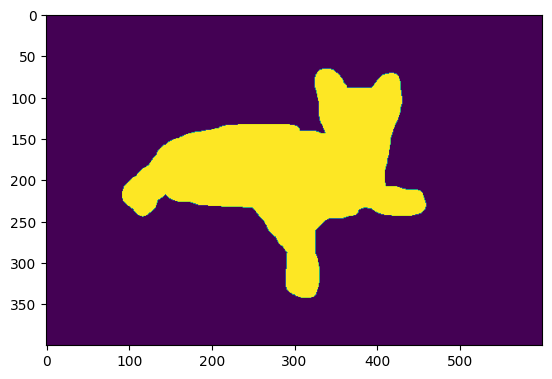

In [ ]:
import numpy as np

# 필요없는 부분은 2 필요한 부분은 1로 되어있는데 이걸 필요한 부분은 1, 필요없는 부분을 0으로 바꿀것이다.
mask = np.array(annotation).astype(np.float32)
mask[mask != 2.0] = 1.0
mask[mask == 2.0] = 0.0
plt.imshow(mask)

In [ ]:
import torch
from torch.utils.data.dataset import Dataset
import torch.nn as nn

In [ ]:
class Pet(Dataset):
    def __init__(self, path_to_img, path_to_anno, train=True, transforms=None, input_size=(128,128)):
        #파일을 불러와서 학습과 평가용으로 분리
        self.images = sorted(glob.glob('./dataset-iiit-pet/images/*.jpg'))
        self.annotations = sorted(glob.glob('./dataset-iiit-pet/annotations/trimaps/*.png'))

        self.X_train = self.images[:int(0.8 * len(self.images))]
        self.X_test = self.images[int(0.8 * len(self.images)) : ]
        self.y_train = self.annotations[:int(0.8 * len(self.annotations))]
        self.y_test = self.annotations[int(0.8 * len(self.annotations)) : ]

        self.train = train
        self.transforms = transforms
        self.input_size = input_size

    def __len__(self):
        if self.train:
            return len(self.X_train)
        else:
            return len(self.X_test)

    def preprocess_mask(self,mask):
        mask = mask.resize(self.input_size)
        mask = np.array(mask).astype(np.float32)
        mask[mask != 2.0] = 1.0
        mask[mask==2.0] = 0.0
        mask = torch.tensor(mask)
        return mask

    def __getitem__(self,i):
        if self.train:
            X_train = Image.open(self.X_train[i])
            X_train = self.transforms(X_train)
            y_train = Image.open(self.y_train[i])
            y_train = self.preprocess_mask(y_train)

            return X_train,y_train

        else:
            X_test = Image.open(self.X_test[i])
            X_test = self.transforms(X_test)
            y_test = Image.open(self.y_test[i])
            y_test = self.preprocess_mask(y_test)

            return X_test,y_test


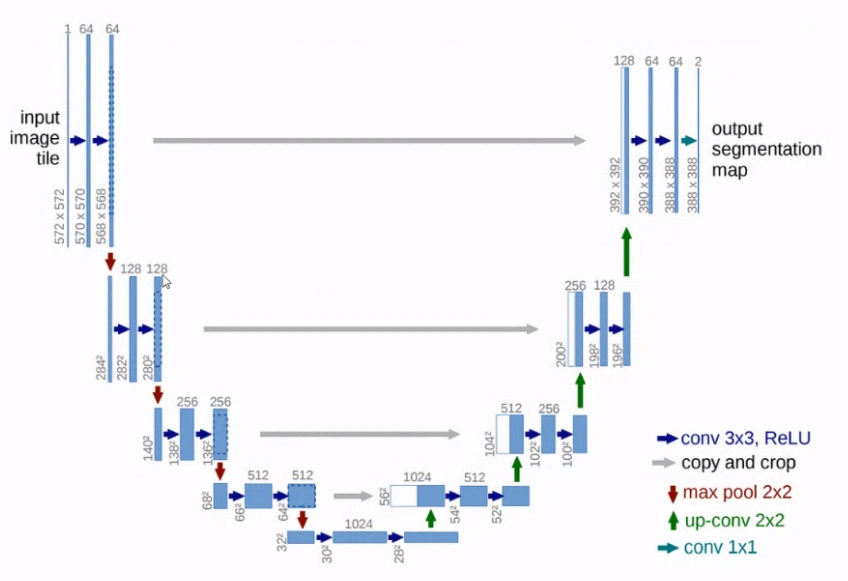

In [ ]:
# unet model 구조
class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()

        #encoder
        self.enc1_1 = nn.Conv2d(3,64,kernel_size=3,padding=1)
        self.enc1_2 = nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2_1 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.enc2_2 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3_1 = nn.Conv2d(128,256,kernel_size=3,padding=1)
        self.enc3_2 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4_1 = nn.Conv2d(256,512,kernel_size=3,padding=1)
        self.enc4_2 = nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc5_1 = nn.Conv2d(512,1024,kernel_size=3,padding=1)
        self.enc5_2 = nn.Conv2d(1024,512,kernel_size=3,padding=1)


        #decoder
        self.upsample4 = nn.ConvTranspose2d(512,512,2,stride=2)
        self.dec4_1 = nn.Conv2d(1024,512,kernel_size=3,padding=1)
        self.dec4_2 = nn.Conv2d(512,256,kernel_size=3,padding=1)

        self.upsample3 = nn.ConvTranspose2d(256,256,2,stride=2)
        self.dec3_1 = nn.Conv2d(512,256,kernel_size=3,padding=1)
        self.dec3_2 = nn.Conv2d(256,128,kernel_size=3,padding=1)

        self.upsample2 = nn.ConvTranspose2d(128,128,2,stride=2)
        self.dec2_1 = nn.Conv2d(256,128,kernel_size=3,padding=1)
        self.dec2_2 = nn.Conv2d(128,64,kernel_size=3,padding=1)

        self.upsample1 = nn.ConvTranspose2d(64,64,2,stride=2)
        self.dec1_1 = nn.Conv2d(128,64,kernel_size=3,padding=1)
        self.dec1_2 = nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.dec1_3 = nn.Conv2d(64,1,kernel_size=3,padding=1)

        self.relu = nn.ReLU()


    def forward(self,x):
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x)
        e1 = self.relu(e1)
        x = self.pool1(e1)

        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x)
        e2 = self.relu(e2)
        x = self.pool2(e2)

        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x)
        e3 = self.relu(e3)
        x = self.pool3(e3)

        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x)
        e4 = self.relu(e4)
        x = self.pool4(e4)

        x = self.enc5_1(x)
        x = self.relu(x)
        x = self.enc5_2(x)
        x = self.relu(x)


        #torch.cat https://jimmy-ai.tistory.com/112
        x = self.upsample4(x)
        x = torch.cat([x,e4],dim=1)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)

        x = self.upsample3(x)
        x = torch.cat([x,e3],dim=1)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)

        x = self.upsample2(x)
        x = torch.cat([x,e2],dim=1)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)

        x = self.upsample1(x)
        x = torch.cat([x,e1],dim=1)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)

        x = torch.squeeze(x)

        return x


In [ ]:
import tqdm
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor,Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
transform = Compose([
    Resize((128,128)),
    ToTensor()
])

train_set = Pet(path_to_img='./dataset-iiit-pet/images',path_to_anno='./dataset-iiit-pet/annotations/trimaps',transforms=transform,train=True)
test_set = Pet(path_to_img='./dataset-iiit-pet/images',path_to_anno='./dataset-iiit-pet/annotations/trimaps',transforms=transform,train=False)

print(len(train_set))
print(len(test_set))

5912
1478


In [ ]:
train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
test_loader = DataLoader(test_set)

model = UNet().to(device)

learning_rate = 0.0001

optim = Adam(params=model.parameters() , lr=learning_rate)

In [ ]:
for epoch in range(200):

    iterator = tqdm.tqdm(train_loader)

    for data,label in iterator:

        optim.zero_grad()

        preds = model(data.to(device))
        loss = nn.BCEWithLogitsLoss() (
            preds, label.type(torch.FloatTensor).to(device)
        )

        loss.backward()

        optim.step()

        iterator.set_description(f'epoch : {epoch+1} loss : {loss.item()}')

    torch.save(model.state_dict(),'unet.pth')

epoch : 171 loss : 0.023847907781600952:  85%|████████▍ | 157/185 [01:17<00:13,  2.07it/s]

In [ ]:
# infer

model.load_state_dict(torch.load('unet.pth', map_location='cpu'))
model = model.to('cpu')

data, label = test_set[1]

pred = model(torch.unsqueeze(data.to('cpu'), dim = 0)) > 0.5

with torch.no_grad():
    plt.imshow(pred)
    plt.imshow(label)

In [ ]:
plt.imshow(label)